# Collaboration and Competition

---

This notebook runs John's solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  It uses the Unity ML-Agents environment to train two cooperative agents to play a tennis-like game.

**Need more description here - refer to readme?**






...


This code depends upon a custom Unity environment provided by the Udacity staff that embodies the variation on tennis.  It will open a separate Unity window for visualizing the environment as the agents train or play.


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from train import train
from maddpg import Maddpg

%matplotlib inline

# create a new Unity environment
# it needs to be done once, outside any loop, as closing an environment then restarting causes
# a Unity exception about the handle no longer being active.
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", seed=0, 
                       no_graphics=True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]                       
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Train the agents

The next cells will invoke the training program to create the agents.  All of the real code is in Python flat files in this project directory.

In [2]:
TRAIN = False
EXPLORE = True

Ready to train over 12 training sets for 20001 episodes each

///// Beginning training set  E16.01  with:
      Bad step prob    =  0.01
      Buffer size      =  10500
      Batch size       =  1000
      Seed             =  468
      Learning every      20  time steps
      Learn iterations =  1
1000	Average score:   0.005,        mem:   1197/    75 ( 6.3%), avg 1535.5 eps/min;  0.2 hr rem   
2000	Average score:   0.005,        mem:   1440/   146 (10.1%), avg 1460.2 eps/min;  0.2 hr rem   
3000	Average score:   0.013,        mem:   1669/   230 (13.8%), avg 1469.4 eps/min;  0.2 hr rem   
4000	Average score:   0.003,        mem:   1905/   288 (15.1%), avg 1483.0 eps/min;  0.2 hr rem   
5000	Average score:   0.005,        mem:   2136/   362 (16.9%), avg 1475.6 eps/min;  0.2 hr rem   
6000	Average score:   0.008,        mem:   2370/   436 (18.4%), avg 1479.0 eps/min;  0.2 hr rem   
7000	Average score:   0.011,        mem:   2595/   514 (19.8%), avg 1485.5 eps/min;  0.1 hr rem   
8000	Ave

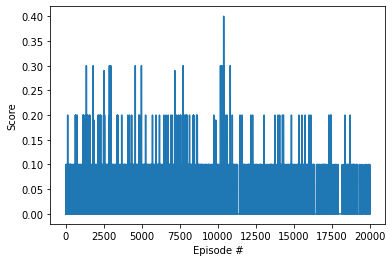


///// Beginning training set  E16.02  with:
      Bad step prob    =  0.01
      Buffer size      =  10500
      Batch size       =  1000
      Seed             =  468
      Learning every      20  time steps
      Learn iterations =  2
1000	Average score:   0.013,        mem:   1229/    87 ( 7.1%), avg 1345.8 eps/min;  0.2 hr rem   
2000	Average score:   0.005,        mem:   1473/   159 (10.8%), avg 1324.9 eps/min;  0.2 hr rem   
2253	Running avg/max: 0.004/0.100,  mem:   1525/   171 (11.2%), avg 1345.6 eps/min   

In [ ]:
# This cell will explore several combinations of hyperparams by training all of them

TIME_STEPS = 200
SAVE_ANALYSIS = False

if EXPLORE:
    
    EPISODES       = 20001
    RUN_PREFIX     = "E16"
    DECAY          = 1.0 #need to test 0.99999; 0.9999 is too small
    SEEDS          = (468, 44939) #(0, 111, 468, 5555, 23100, 44939)
    BAD_STEP_PROBS = (0.01,)
    BATCHES        = (1000,)
    LEARN_EVERYS   = (20, 30, 40)
    LEARN_ITERS    = (1, 2)
    
    num_sets = len(BAD_STEP_PROBS) * len(BATCHES ) * len(SEEDS) * len(LEARN_EVERYS) * len(LEARN_ITERS)
    print("Ready to train over {} training sets for {} episodes each".format(num_sets, EPISODES))
    set_id = 0
    for BAD_STEP_PROB in BAD_STEP_PROBS:
        for BATCH in BATCHES:
            for SEED in SEEDS:
                for LEARN_EVERY in LEARN_EVERYS:
                    for LEARN_ITER in LEARN_ITERS:
                        
                        # set the replay buffer size to that it fills after ~5000 bad episodes
                        # (at ~14 experiences/episode), based on the bad step retention rate
                        buffer_size = int(60000 - 50000*(1.0 - BAD_STEP_PROB))
                        
                        set_id += 1
                        RUN_NAME = "{}.{:02d}".format(RUN_PREFIX, set_id)
                        print("\n///// Beginning training set ", RUN_NAME, " with:")
                        print("      Bad step prob    = ", BAD_STEP_PROB)
                        print("      Buffer size      = ", buffer_size)
                        print("      Batch size       = ", BATCH)
                        print("      Seed             = ", SEED)
                        print("      Learning every     ", LEARN_EVERY, " time steps")
                        print("      Learn iterations = ", LEARN_ITER)
    
                        ##### instantiate the agents and perform the training

                        maddpg = Maddpg(state_size, action_size, 2, bad_step_prob=BAD_STEP_PROB,
                                        random_seed=SEED, batch_size=BATCH, buffer_size=buffer_size,
                                        noise_decay=DECAY, learn_every=LEARN_EVERY, learn_iter=LEARN_ITER)

                        scores = train(maddpg, env, run_name=RUN_NAME, max_episodes=EPISODES, 
                                       winning_score=0.5, max_time_steps=TIME_STEPS,
                                       checkpoint_interval=1000)

                        ##### plot the training reward history

                        fig = plt.figure()
                        ax = fig.add_subplot(111)
                        plt.plot(np.arange(len(scores)), scores)
                        plt.ylabel('Score')
                        plt.xlabel('Episode #')
                        plt.show()
                        
                        ##### store the action/noise data, if being used
                        
                        if SAVE_ANALYSIS:
                            maddpg.save_anal_data()
                        
    print("\n\nDONE!")

# HEY JOHN - TODO!

- update main.py to match the above code {ALL CELLS}
- Test running from cmd line (may need a script?)
- Clean up the bottom part of this notebook

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
"""
for i in range(10):                                        # play game for several episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations             3     # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    num_steps = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        num_steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Episode {}: {:5.3f}, took {} steps'.format(i, np.max(scores), num_steps))
"""

When finished, you can close the environment.

In [ ]:
env.close()